In [9]:
%%capture
cd ..

In [10]:

from model import Matuszynska2016

In [11]:
from modelbase2 import Simulator
import itertools as it
from typing import Iterable, Dict, Tuple, Optional, Any, List, Union
from tqdm.notebook import tqdm
from modelbase2 import make_protocol
from scipy.signal import find_peaks, peak_prominences

In [12]:
Matuszynska2016().get_stoichiometries()

,v_PSII,v_PQ,v_ATPsynth,v_Leak,v_ATPcons,v_ATPact,v_Xcyc,v_PsbSP
PQH_2,1.00,-1.00,0.000000,0.00,0.0,0.0,0.0,0.0
H_lu,0.02,0.04,-0.046667,-0.01,0.0,0.0,0.0,0.0
ATP_st,0.00,0.00,1.000000,0.00,-1.0,0.0,0.0,0.0
ATPase_ac,0.00,0.00,0.000000,0.00,0.0,1.0,0.0,0.0
Vx,0.00,0.00,0.000000,0.00,0.0,0.0,-1.0,0.0
psbS,0.00,0.00,0.000000,0.00,0.0,0.0,0.0,-1.0


In [13]:
def pam2(
    s: Simulator,
    t_relax: float, #Duration of relaxtion
    t_pulse: float, #Duration of Pulse
    numpeaks_phase0: float,
    numpeaks_phase1: float,
    pfd_dark: float,
    pfd_illumination: float,
    pfd_pulse: float,
    max_duration: float = 2500,
):
    step_duration = t_relax + t_pulse
    max_steps = int(max_duration // step_duration) + 1
    
    pfds = list(
        [pfd_dark, pfd_pulse] * numpeaks_phase0 + [pfd_illumination, pfd_pulse] * numpeaks_phase1 + [pfd_dark, pfd_pulse] * (max_steps - (numpeaks_phase0 + numpeaks_phase1))
        
    )
    time_points = list(it.chain.from_iterable((t_relax, t_pulse) for i in range(max_steps)))
    
    ptrc = [
        (t_end, {'pfd': pfd}) for t_end, pfd in zip(time_points, pfds)
    ]
    
    pam_ptrc = make_protocol(ptrc)
    
    s.simulate_over_protocol(pam_ptrc, 100)
    
    return s, pam_ptrc

def npq2(
    s: Simulator,
    peak_distance: float
):
    
    fluo_results = s.get_full_concs()['Fluo'] / max(s.get_full_concs()['Fluo'])
    
    # Find the Flourescence peaks (Fmaxs)
    peaks, _ = find_peaks(fluo_results, distance=peak_distance, height=0)
    
    # Get time at peaks
    time = s.get_full_concs().iloc[peaks].index
    
    # Calculate Fm
    Fm = fluo_results.iloc[peaks].values
    
    #Calculate NPQ
    NPQ = (Fm[0] - Fm) / Fm
    
    # Find the minima around the peaks
    prominences, prominences_left, prominences_right = peak_prominences(
                (fluo_results), peaks
            )  
    
    # Fo is always the minima before the peak
    Fo = s.get_full_concs()['Fluo'].iloc[prominences_left].values
    
    return time, Fm, NPQ, Fo

In [ ]:
pam_ptrc = make_protocol(
    [
        (30, {"pfd": 10}),
        ()
    ]
)

In [18]:
s1 = Simulator(Matuszynska2016())
s1.clear_results()

t_relax=120
t_pulse=0.8
numpeaks_phase0=2
numpeaks_phase1=10
pfd_dark=50
pfd_illumination=1000
pfd_pulse=5000

s1, pam_ptrc = pam2(
    s1,
    t_relax=t_relax,
    t_pulse=t_pulse,
    numpeaks_phase0=numpeaks_phase0,
    numpeaks_phase1=numpeaks_phase1,
    pfd_dark=pfd_dark,
    pfd_illumination=pfd_illumination,
    pfd_pulse=pfd_pulse,
)

print(pam_ptrc)

                         pfd
Timedelta                   
0 days 00:02:00           50
0 days 00:02:00.800000  5000
0 days 00:04:00.800000    50
0 days 00:04:01.600000  5000
0 days 00:06:01.600000  1000
0 days 00:06:02.400000  5000
0 days 00:08:02.400000  1000
0 days 00:08:03.200000  5000
0 days 00:10:03.200000  1000
0 days 00:10:04         5000
0 days 00:12:04         1000
0 days 00:12:04.800000  5000
0 days 00:14:04.800000  1000
0 days 00:14:05.600000  5000
0 days 00:16:05.600000  1000
0 days 00:16:06.400000  5000
0 days 00:18:06.400000  1000
0 days 00:18:07.200000  5000
0 days 00:20:07.200000  1000
0 days 00:20:08         5000
0 days 00:22:08         1000
0 days 00:22:08.800000  5000
0 days 00:24:08.800000  1000
0 days 00:24:09.600000  5000
0 days 00:26:09.600000    50
0 days 00:26:10.400000  5000
0 days 00:28:10.400000    50
0 days 00:28:11.200000  5000
0 days 00:30:11.200000    50
0 days 00:30:12         5000
0 days 00:32:12           50
0 days 00:32:12.800000  5000
0 days 00:34:1

[ERROR][rank 0][/home/conda/feedstock_root/build_artifacts/sundials-split_1744094662001/work/sundials/src/cvodes/cvodes.c:8101][cvHandleFailure] At t = 1570.47075085294 and h = 0.0020407143211583, the corrector convergence test failed repeatedly or with |h| = hmin.


None


TypeError: 'NoneType' object is not subscriptable

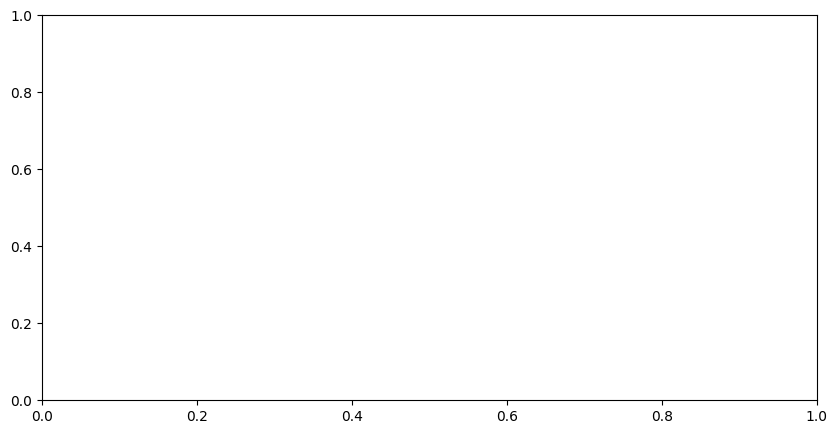

In [16]:
from modelbase2 import plot
import matplotlib.pyplot as plt
    
c = s1.get_full_concs()
print(c)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(c["Fluo"] / max(c["Fluo"]), color="red", lw=2.5)
# ax.plot(time, NPQ, linestyle="dashed", color="black", label="NPQ", lw=2)

pam_ptrc_cleaned = pam_ptrc[pam_ptrc['pfd'] != pfd_pulse]

plot.shade_protocol(
    pam_ptrc_cleaned['pfd'],
    ax=ax,
    vmin=pfd_dark,
    vmax=pfd_illumination,
    add_legend=False,
    alpha=0.3
)

ax.set(
    ylim=(0, 1.1),
    xlim=(0, 2500),
    xlabel="Time/(s)",
    ylabel="Fluorescence (normalised)",
)
ax.legend(loc="lower right")
plt.show()